<center><h1>Let's help ladies buy quality Human Hair Wigs</h1></center>

In [1]:
# crawl images from website
from bs4 import BeautifulSoup
import requests
import boto3, uuid

In [2]:
session = requests.session()
s3 = boto3.resource('s3')

In [3]:
base_uri = "https://www.glamorousremihair.com"

synthetic_hair = f"{base_uri}/SYNTHETIC-HAIR-c43110/"
human_hair = f"{base_uri}/Human-Hair-Wigs-c22050/"

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1941.0 Safari/537.36'
}

bucket = 'gram-to-store-images'

payload = session.get(human_hair, headers=headers) # 

In [39]:
bs_parsed = BeautifulSoup(payload.content, 'html.parser')

In [70]:
links = bs_parsed.find('div', class_='bd').find_all('a')
img_urls = []
for link in links:
    img = link.find('img')
    if img is not None:
        img_url = link.find('img').get('_src')
        img_urls.append(img_url.split('?')[0])

### Data Scraping Functions

In [21]:
def crawl_main_page(url: str, product_class: str):
    """
    """
    response = session.get(url, headers=headers) #
    parsed_response = BeautifulSoup(response.content, 'html.parser')
    products = parsed_response.find('div', class_='categry_list').find_all('li')
    result = []
    for product in products:
        price = product.find('em').text
        old_price = product.find('del').text
        name = product.find('span', class_='products_title').text
        path = product.find('a').get('href')
        inner_page_link = f'{base_uri}{path}'
        imgs = crawl_inner_page(inner_page_link, product_class)
        data = {
            'imageInfo': imgs,
            'price': price,
            'oldPrice': old_price,
            'productTitle': name,
            'productLink': inner_page_link
        }
        result.append(data)
    return result

In [18]:
def crawl_inner_page(inner_page_url: str, image_class: str):
    """
    """
    response = session.get(inner_page_url, headers=headers)
    parsed_response = BeautifulSoup(response.content, 'html.parser')
    links = parsed_response.find('div', class_='bd').find_all('a')
    img_urls = []
    for link in links:
        img = link.find('img')
        if img is not None:
            img_url = link.find('img').get('_src').split('?')[0]
            s3_path = upload_image_to_s3(img_url, image_class)
            img_urls.append({ 'image_link': img_url, 's3_path': s3_path })
    return img_urls

In [19]:
def upload_image_to_s3(raw_img_url: str, image_class: str = 'human-hair'):
    """
    """
    image_id = str(uuid.uuid1())
    req_for_image = session.get(raw_img_url, stream=True)
    file_object_from_req = req_for_image.raw
    req_data = file_object_from_req.read()
    image_s3_key = f'dataset/wigs/{image_class}/{image_id}.png'
    s3.Bucket(bucket)\
        .put_object(Key=image_s3_key, Body=req_data)
    return f's3://{bucket}/{image_s3_key}'

In [22]:
scraped_human_hair = crawl_main_page(human_hair, 'human-hair')

In [ ]:
scraped_synthetic_hair = crawl_main_page(synthetic_hair, 'synthetic-hair')

2


# Identify Sythetic or Human Hair Wigs with Machine Learning

The hair extensions industry is a multi-billion dollar global industry. [According to China Customs](https://www.scmp.com/business/china-business/article/3011657/chinas-wig-capital-has-designs-africa-us-tariffs-loom), China's wig exports reached excess of $2 billion dollar, with US being the largest destination. However, wig manufacturers in China are moving focus from US to Africa.


![](https://cdn.i-scmp.com/sites/default/files/d8/images/methode/2019/05/26/c2a3a5a4-7dfa-11e9-8126-9d0e63452fe9_972x_091652.jpg)


After speaking with a handful of ladies, one of the major challenges experienced by shoppers is **Trust** which is rooted in vendors selling synthetic hair (low quality) and human hair. Also speaking with vendors, it turns out that differentiating between both synthetic hair and human hair wigs can be challenging. One only knows when the hair is made or wig is bought and used. This appears like a classic task for [Image Classification](https://www.tensorflow.org/tutorials/images/classification).


In this tutorial, we will train an image classification model using [Amazon SageMaker built-in algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html). A next step might be to train an [image segmentation model](https://docs.aws.amazon.com/sagemaker/latest/dg/semantic-segmentation.html) to identify hair quality at pixel level.

#### Hypothesis
If we are able to differentiate between **synthetic** and **human hair** wigs with images right before customers complete their purchase, then we can help customers can build trust with hair vendors. We will know that we succeeded if we achieve **65%** accuracy with our machine learning model.


#### Data set
We scraped wig images for both classes, synthetic and human hair wigs, from [Glamorous Remi](https://www.glamorousremihair.com) an online store for wigs and hair extensions. Images are stored in [Amazon S3](https://aws.amazon.com/s3/) which will then be accessed by [Amazon SageMaker](https://aws.amazon.com/sagemaker/) for model training

### Prequisites and Preprocessing

#### Permissions and environment variables
Here we set up the linkage and authentication to AWS services. There are three parts to this:

- The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
- The S3 bucket that you want to use for training and model data
- The Amazon sagemaker image classification docker image which need not be changed

In [1]:
%%time
import boto3
import re
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()
sess = sagemaker.Session()

bucket = ''
prefix = 'ml-dataset'

training_image = get_image_uri(boto3.Session().region_name, 'image-classification')

CPU times: user 892 ms, sys: 127 ms, total: 1.02 s
Wall time: 1.67 s


#### Data preparation
Raw images have already downloaded to [Amazon S3](https://aws.amazon.com/s3/). We then need to convert the images into [Apache MxNet RecordIO format](https://mxnet.apache.org/api/faq/recordio) and then transfer to S3 for use in training.

In [8]:
!wget https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py

--2020-05-01 15:07:54--  https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.24.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.24.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15838 (15K) [text/plain]
Saving to: 'im2rec.py'

im2rec.py           100%[===================>]  15.47K  --.-KB/s    in 0s      

2020-05-01 15:07:54 (101 MB/s) - 'im2rec.py' saved [15838/15838]



In [21]:
# !pip install opencv-python
# !pip install split-folders

In [19]:
# !aws s3 cp s3://gram-to-store-images/dataset/wigs/ dataset/ --recursive

In [23]:
!split_folders dataset/ --output output --ratio .8 .2

Copying files: 236 files [00:14, 16.16 files/s]


In [25]:
%%bash

python im2rec.py --list --recursive wig-classification-train output/train/
python im2rec.py --list --recursive wig-classification-val output/validation/

human-hair 0
synthetic-hair 1
human-hair 0
synthetic-hair 1


In [16]:
!mkdir dataset

In [26]:
!head -n 3 ./wig-classification-train.lst > example.lst
f = open('example.lst','r')
lst_content = f.read()
print(lst_content)

69	0.000000	human-hair/c65f97aa-8bac-11ea-9da4-955a1485f3bf.png
163	1.000000	synthetic-hair/8af093e4-8bad-11ea-9da4-955a1485f3bf.png
158	1.000000	synthetic-hair/7d7b3552-8bad-11ea-9da4-955a1485f3bf.png



In [3]:
# Four channels: train, validation, train_lst, and validation_lst
s3_train = 's3://{}/{}/train/'.format(bucket, prefix)
s3_validation = 's3://{}/{}/validation/'.format(bucket, prefix)
s3_train_lst = 's3://{}/{}/train_lst/'.format(bucket, prefix)
s3_validation_lst = 's3://{}/{}/validation_lst/'.format(bucket, prefix)


In [33]:
# upload the image files to train and validation channels
!aws s3 cp output/train/ $s3train --recursive --quiet
!aws s3 cp output/validation/ $s3validation --recursive --quiet

# upload the lst files to train_lst and validation_lst channels
!aws s3 cp wig-classification-train.lst $s3_train_lst --quiet
!aws s3 cp wig-classification-val.lst $s3_validation_lst --quiet

's3://gram-to-store-images/ml-dataset/validation/'

In [ ]:
## convert images to RecordIO format (optional)
%%bash
python im2rec.py --resize 256 --quality 90 --num-thread 16 output/train/
python im2rec.py --resize 256 --quality 90 --num-thread 16 output/validation/

### Fine-tuning the Image Classification Model

Once we have the data available in the correct format for training, the next step is to actually train the model using the data. Before training the model, we need to setup the training parameters. The next section will explain the parameters in detail.


#### Training parameters
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:

- Training instance count: This is the number of instances on which to run the training. When the number of instances is greater than one, then the image classification algorithm will run in distributed settings.
- Training instance type: This indicates the type of machine on which to run the training. Typically, we use GPU instances for these training
- Output path: This the s3 folder in which the training output is stored

In [4]:
train_use_spot_instances = True
train_max_run=1300
train_max_wait = 2400 if train_use_spot_instances else None

In [12]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

image_classifier = sagemaker.estimator.Estimator(
    training_image,
    role, 
    train_instance_count=1, 
    train_instance_type='ml.p2.xlarge',
    train_volume_size = 50,
    input_mode= 'File',
    train_use_spot_instances=train_use_spot_instances,
    train_max_run=train_max_run,
    train_max_wait=train_max_run,    
    output_path=s3_output_location,
    sagemaker_session=sess
)

Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. These are:

- num_layers: The number of layers (depth) for the network. We use 18 in this samples but other values such as 50, 152 can be used.
- use_pretrained_model: Set to 1 to use pretrained model for transfer learning.
- image_shape: The input image dimensions,'num_channels, height, width', for the network. It should be no larger than the actual image size. The number of channels should be same as the actual image.
- num_classes: This is the number of output classes for the new dataset. Imagenet was trained with 1000 output classes but the number of output classes can be changed for fine-tuning. For this example, we have 2 classes.
- num_training_samples: This is the total number of training samples. It is set to 191.
- mini_batch_size: The number of training samples used for each mini batch. In distributed training, the number of training samples used per batch will be N * mini_batch_size where N is the number of hosts on which training is run.
- epochs: Number of training epochs.
- learning_rate: Learning rate for training.
- top_k: Report the top-k accuracy during training.
- resize: Resize the image before using it for training. The images are resized so that the shortest side is of this parameter. If the parameter is not set, then the training data is used as such without resizing.
- precision_dtype: Training datatype precision (default: float32). If set to 'float16', the training will be done in mixed_precision mode and will be faster than float32 mode

In [16]:
image_classifier.set_hyperparameters(
    num_layers=18,
    use_pretrained_model=1,
    image_shape = "3,224,224",
    num_classes=2,
    epochs=10,
    learning_rate=0.01,
    top_k=2,
    num_training_samples=191,
    resize = 256,
    precision_dtype='float32'
)

### Input data specification
Set the data type and channels used for training

In [7]:
train_data = sagemaker.session.s3_input(s3_train, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')
train_data_lst = sagemaker.session.s3_input(s3_train_lst, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data_lst = sagemaker.session.s3_input(s3_validation_lst, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_lst': train_data_lst, 'validation_lst': validation_data_lst}

### Start the training
Start training by calling the fit method in the estimator

In [17]:
image_classifier.fit(inputs=data_channels, logs=True)

2020-05-01 16:41:56 Starting - Starting the training job...
2020-05-01 16:41:58 Starting - Launching requested ML instances......
2020-05-01 16:42:57 Starting - Preparing the instances for training......
2020-05-01 16:44:20 Downloading - Downloading input data...
2020-05-01 16:44:54 Training - Downloading the training image......
2020-05-01 16:45:56 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[05/01/2020 16:46:00 INFO 140268203599680] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weight_decay': 0.0001, u'learning_rate': 0.1, u'momentum': 0}
[05/01/2020 16:46:00 INFO 140268203599680] 

First run, 2 epochs, with the following accuracy metrics:
- Train accuracy: 0.912500
- Validation-accuracy: 0.812500

We also trained on Spot instances saving 69.8% of the cost.


#### Hypothesis Validation
Based on the acceptance criterion defined above hypothesis, we can proceed to deploy our model into production. The deployment is completed with the Amazon SageMaker Endpoint.

Further model improvements, Amazon SageMaker Automatic Hyperparameter Tuning will be used. For real-life, constant retraining of the model and evaluation with Human-In-the-Loop with [Amazon Augmented AI (Amazon A2I](https://aws.amazon.com/augmented-ai/)

### Inference

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting whether a wig is synthetic or human hair. You can deploy the created model by using the deploy method in the estimator

In [18]:
wig_classifier = image_classifier.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

---------------!

#### Download test image

For tests, we will download a images of synthetic and human hair wigs from [AliExpress.com](https://www.aliexpress.com/) to see the performance of our model on new data.

The image used is a synthetic hair wig from [Short Synthetic Wigs Afro Kinky Curly Wig for Women](https://www.aliexpress.com/item/4000087433595.html)

--2020-05-01 17:01:41--  https://ae01.alicdn.com/kf/H8b032486d1ee44959e38185e441546d4o.jpg
Resolving ae01.alicdn.com (ae01.alicdn.com)... 23.212.228.96
Connecting to ae01.alicdn.com (ae01.alicdn.com)|23.212.228.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 303699 (297K) [image/jpeg]
Saving to: '/tmp/test.jpg'

/tmp/test.jpg       100%[===================>] 296.58K  --.-KB/s    in 0.06s   

2020-05-01 17:01:42 (5.16 MB/s) - '/tmp/test.jpg' saved [303699/303699]



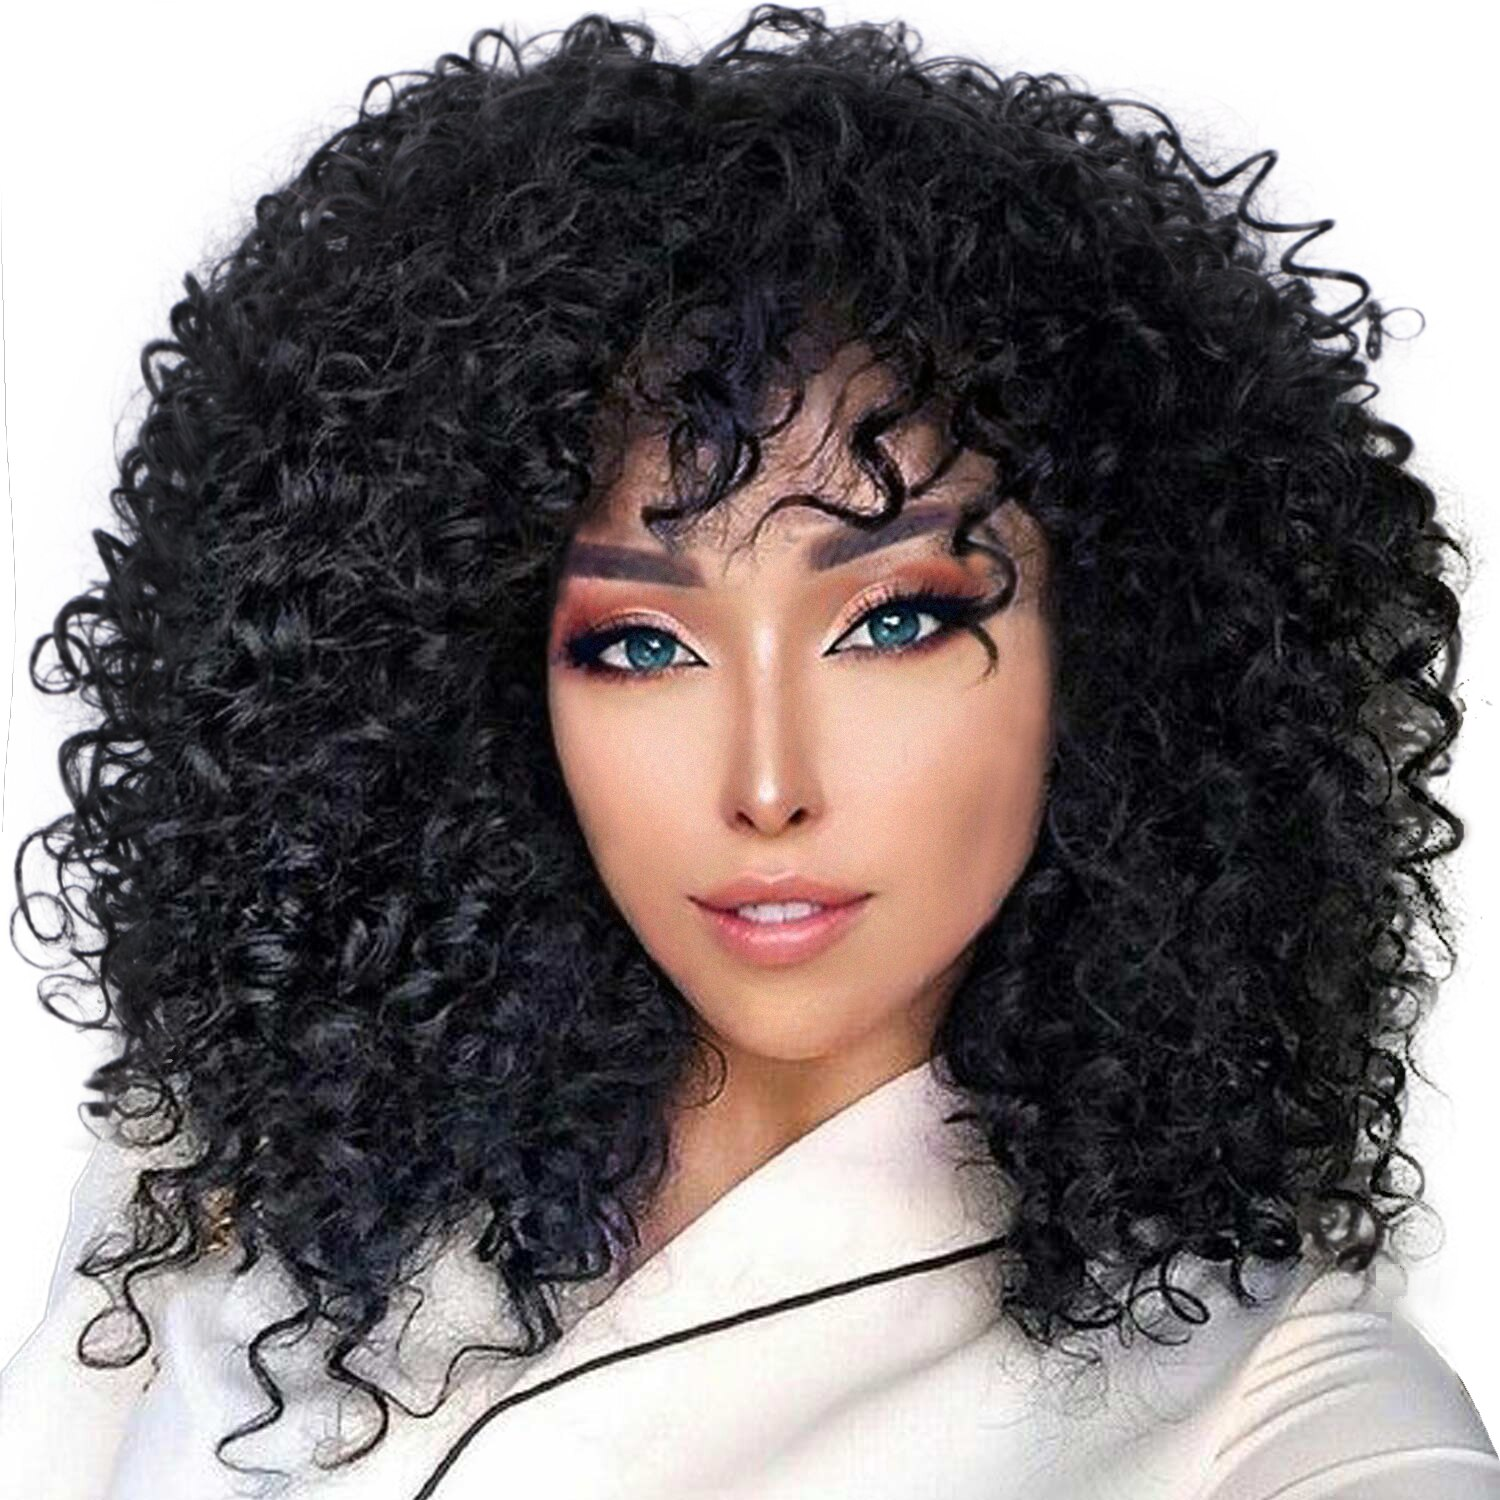

In [19]:
!wget -O /tmp/test.jpg https://ae01.alicdn.com/kf/H8b032486d1ee44959e38185e441546d4o.jpg
file_name = '/tmp/test.jpg'
# test image
from IPython.display import Image
Image(file_name)

In [22]:
import json
import numpy as np

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
    
wig_classifier.content_type = 'application/x-image'
result = json.loads(wig_classifier.predict(payload))

In [23]:
result

[8.7064785475377e-05, 0.9999129772186279]

In [24]:
index = np.argmax(result)
object_categories = ['human-hair', 'synthetic-hair']

print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

Result: label - synthetic-hair, probability - 0.9999129772186279
